# NFL Big Data Bowl 2026 - ST Transformer Training

This notebook demonstrates how to train the 6-Layer Spatial-Temporal Transformer model.

**Model**: ST Transformer (6 layers) - Our best single model (0.547 Public LB)

**Contents:**
1. Setup and imports
2. Load and preprocess data
3. Define the ST Transformer model
4. Train with 5-fold CV (quick demo)
5. Evaluate and visualize results
6. Save trained model

**Note**: This is a simplified demo using 5-fold CV. For production models, use 20-fold CV.

In [1]:
# Imports
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

# Add src to path (if using package structure)
sys.path.insert(0, '../src')

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

# Set seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print('✓ Imports successful')

Device: cuda
✓ Imports successful


## 1. Configuration

In [2]:
class Config:
    """Training configuration"""
    
    # Data
    DATA_DIR = Path('/mnt/raid0/Kaggle Big Data Bowl/data/raw')  # Update this
    WINDOW_SIZE = 10  # frames of history
    MAX_FUTURE_HORIZON = 94  # max future frames to predict
    
    # Model
    HIDDEN_DIM = 128
    N_LAYERS = 6  # transformer layers
    N_HEADS = 8   # attention heads
    N_QUERYS = 2  # pooling queries
    MLP_HIDDEN_DIM = 256
    N_RES_BLOCKS = 2
    
    # Training
    N_FOLDS = 5  # Use 5 for demo, 20 for production
    BATCH_SIZE = 256
    LEARNING_RATE = 1e-3
    EPOCHS = 100
    PATIENCE = 15
    
    # Augmentation
    HORIZONTAL_FLIP = True
    
    # Field dimensions
    FIELD_X_MAX = 120.0
    FIELD_Y_MAX = 53.3
    
    # Output
    OUTPUT_DIR = Path('../models/st_transformer_demo')
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

cfg = Config()
print(f"Configuration:")
print(f"  Window size: {cfg.WINDOW_SIZE}")
print(f"  Hidden dim: {cfg.HIDDEN_DIM}")
print(f"  Layers: {cfg.N_LAYERS}")
print(f"  Folds: {cfg.N_FOLDS}")
print(f"  Batch size: {cfg.BATCH_SIZE}")
print(f"  Output: {cfg.OUTPUT_DIR}")

Configuration:
  Window size: 10
  Hidden dim: 128
  Layers: 6
  Folds: 5
  Batch size: 256
  Output: ../models/st_transformer_demo


## 2. Data Loading & Preprocessing

In [3]:
def horizontal_flip_dataframe(df):
    """Apply horizontal flip augmentation"""
    df = df.copy()
    field_width = 53.3
    
    if 'y' in df.columns:
        df['y'] = field_width - df['y']
    
    for col in ['velocity_y', 'acceleration_y']:
        if col in df.columns:
            df[col] = -df[col]
    
    if 'dir' in df.columns:
        df['dir'] = (180 - df['dir']) % 360
    if 'o' in df.columns:
        df['o'] = (180 - df['o']) % 360
    
    return df

print('✓ Augmentation function defined')

✓ Augmentation function defined


In [4]:
# Load data (for demo, use 2-3 weeks)
print("Loading training data...")

weeks_to_load = [1, 2]  # For demo; use all weeks for production
input_dfs = []
output_dfs = []

for week in weeks_to_load:
    input_file = cfg.DATA_DIR / f'input_2023_w{week:02d}.csv'
    output_file = cfg.DATA_DIR / f'output_2023_w{week:02d}.csv'
    
    if input_file.exists() and output_file.exists():
        input_dfs.append(pd.read_csv(input_file))
        output_dfs.append(pd.read_csv(output_file))
        print(f"  ✓ Week {week}")

train_input = pd.concat(input_dfs, ignore_index=True)
train_output = pd.concat(output_dfs, ignore_index=True)

print(f"\nLoaded:")
print(f"  Input:  {len(train_input):,} rows")
print(f"  Output: {len(train_output):,} rows")
print(f"  Plays:  {train_input.groupby(['game_id', 'play_id']).ngroups:,}")

Loading training data...
  ✓ Week 1
  ✓ Week 2

Loaded:
  Input:  574,300 rows
  Output: 64,268 rows
  Plays:  1,669


In [5]:
# Apply augmentation
if cfg.HORIZONTAL_FLIP:
    print("\nApplying horizontal flip augmentation...")
    
    train_input_flip = horizontal_flip_dataframe(train_input.copy())
    train_output_flip = horizontal_flip_dataframe(train_output.copy())
    
    # Add suffix to game_id to distinguish flipped data
    train_input_flip['game_id'] = train_input_flip['game_id'].astype(str) + '_flip'
    train_output_flip['game_id'] = train_output_flip['game_id'].astype(str) + '_flip'
    
    # Combine
    train_input_combined = pd.concat([train_input, train_input_flip], ignore_index=True)
    train_output_combined = pd.concat([train_output, train_output_flip], ignore_index=True)
    
    print(f"  Original:  {len(train_input):,} rows")
    print(f"  Augmented: {len(train_input_combined):,} rows (2x)")
else:
    train_input_combined = train_input
    train_output_combined = train_output


Applying horizontal flip augmentation...
  Original:  574,300 rows
  Augmented: 1,148,600 rows (2x)


## 3. Feature Engineering

**Note**: For a complete implementation, you would use the preprocessing code from `src/data/preprocessing.py`. Here's a simplified version:

In [6]:
def add_basic_features(df):
    """Add basic derived features"""
    df = df.copy()
    
    # Velocity components
    dir_rad = np.deg2rad(df['dir'].fillna(0))
    df['velocity_x'] = df['s'] * np.sin(dir_rad)
    df['velocity_y'] = df['s'] * np.cos(dir_rad)
    
    # Acceleration components
    df['acceleration_x'] = df['a'] * np.cos(dir_rad)
    df['acceleration_y'] = df['a'] * np.sin(dir_rad)
    
    # Distance to ball
    if 'ball_land_x' in df.columns:
        dx = df['ball_land_x'] - df['x']
        dy = df['ball_land_y'] - df['y']
        df['distance_to_ball'] = np.sqrt(dx**2 + dy**2)
        df['angle_to_ball'] = np.arctan2(dy, dx)
    
    # Role indicators
    df['is_receiver'] = (df['player_role'] == 'Targeted Receiver').astype(int)
    df['is_passer'] = (df['player_role'] == 'Passer').astype(int)
    df['is_coverage'] = (df['player_role'] == 'Defensive Coverage').astype(int)
    
    return df

# Apply feature engineering
print("Engineering features...")
train_input_fe = add_basic_features(train_input_combined)
print("✓ Features added")

Engineering features...
✓ Features added


In [7]:
def prepare_sequences(input_df, output_df, window_size=10):
    """
    Prepare sequences for training
    
    Returns:
        sequences: List of (window_size, num_features) arrays
        targets: List of (horizon, 2) arrays for dx, dy predictions
        metadata: List of dicts with game_id, play_id, nfl_id
    """
    # Define feature columns (simplified for demo)
    feature_cols = [
        'x', 'y', 's', 'a', 'dir', 'o',
        'velocity_x', 'velocity_y', 
        'acceleration_x', 'acceleration_y',
        'distance_to_ball', 'angle_to_ball',
        'is_receiver', 'is_passer', 'is_coverage',
        'frame_id'
    ]
    
    # Filter to available columns
    feature_cols = [c for c in feature_cols if c in input_df.columns]
    
    sequences = []
    targets = []
    metadata = []
    
    # Group by player trajectory
    for (game_id, play_id, nfl_id), group in tqdm(input_df.groupby(['game_id', 'play_id', 'nfl_id']), 
                                                     desc="Preparing sequences"):
        # Sort by frame
        group = group.sort_values('frame_id')
        
        # Take last window_size frames as input
        input_window = group.tail(window_size)
        
        if len(input_window) < window_size:
            # Pad if needed
            pad_len = window_size - len(input_window)
            pad_df = pd.DataFrame(
                np.nan, 
                index=range(pad_len), 
                columns=input_window.columns
            )
            input_window = pd.concat([pad_df, input_window], ignore_index=True)
        
        # Get output trajectory
        output_traj = output_df[
            (output_df['game_id'] == game_id) &
            (output_df['play_id'] == play_id) &
            (output_df['nfl_id'] == nfl_id)
        ].sort_values('frame_id')
        
        if len(output_traj) == 0:
            continue
        
        # Get last position from input
        last_x = input_window['x'].iloc[-1]
        last_y = input_window['y'].iloc[-1]
        
        # Compute displacements (dx, dy) from last position
        dx = output_traj['x'].values - last_x
        dy = output_traj['y'].values - last_y
        
        # Pad to max horizon
        target = np.zeros((cfg.MAX_FUTURE_HORIZON, 2))
        horizon = min(len(dx), cfg.MAX_FUTURE_HORIZON)
        target[:horizon, 0] = dx[:horizon]
        target[:horizon, 1] = dy[:horizon]
        
        # Extract features
        seq = input_window[feature_cols].fillna(0).values
        
        sequences.append(seq)
        targets.append(target)
        metadata.append({
            'game_id': game_id,
            'play_id': play_id,
            'nfl_id': nfl_id,
            'last_x': last_x,
            'last_y': last_y
        })
    
    return sequences, targets, metadata, feature_cols

# Prepare sequences
sequences, targets, metadata, feature_cols = prepare_sequences(
    train_input_fe, 
    train_output_combined,
    window_size=cfg.WINDOW_SIZE
)

print(f"\n✓ Prepared {len(sequences):,} sequences")
print(f"  Sequence shape: {sequences[0].shape}")
print(f"  Target shape: {targets[0].shape}")
print(f"  Features: {len(feature_cols)}")

Preparing sequences:   0%|          | 0/41214 [00:00<?, ?it/s]


✓ Prepared 10,874 sequences
  Sequence shape: (10, 16)
  Target shape: (94, 2)
  Features: 16


## 4. Define ST Transformer Model

In [8]:
class ResidualMLP(nn.Module):
    """Residual MLP block"""
    def __init__(self, d_in, d_hidden, d_out, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(d_in, d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_hidden)
        self.proj = nn.Linear(d_in, d_hidden) if d_in != d_hidden else nn.Identity()
        self.out = nn.Linear(d_hidden, d_out)
        self.drop = nn.Dropout(dropout)
        self.act = nn.GELU()
        
    def forward(self, x):
        h = self.drop(self.act(self.fc1(x)))
        h = self.drop(self.act(self.fc2(h)) + self.proj(x))
        return self.out(h)


class STTransformer(nn.Module):
    """Spatial-Temporal Transformer"""
    
    def __init__(self, input_dim):
        super().__init__()
        
        self.horizon = cfg.MAX_FUTURE_HORIZON
        self.hidden_dim = cfg.HIDDEN_DIM
        self.n_heads = cfg.N_HEADS
        self.n_layers = cfg.N_LAYERS
        self.n_querys = cfg.N_QUERYS
        
        # Input projection
        self.input_proj = nn.Linear(input_dim, self.hidden_dim)
        
        # Positional encoding
        self.pos_embed = nn.Parameter(torch.randn(1, cfg.WINDOW_SIZE, self.hidden_dim))
        self.embed_dropout = nn.Dropout(0.1)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.hidden_dim,
            nhead=self.n_heads,
            dim_feedforward=self.hidden_dim * 4,
            dropout=0.1,
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=self.n_layers
        )
        
        # Pooling with attention
        self.pool_ln = nn.LayerNorm(self.hidden_dim)
        self.pool_attn = nn.MultiheadAttention(
            self.hidden_dim, 
            num_heads=self.n_heads, 
            batch_first=True
        )
        self.pool_query = nn.Parameter(torch.randn(1, self.n_querys, self.hidden_dim))
        
        # Output head
        self.head = ResidualMLP(
            d_in=self.n_querys * self.hidden_dim,
            d_hidden=cfg.MLP_HIDDEN_DIM,
            d_out=self.horizon * 2
        )
    
    def forward(self, x):
        """
        Args:
            x: (batch, window_size, input_dim)
        Returns:
            out: (batch, horizon, 2) - cumulative (dx, dy)
        """
        B, T, _ = x.shape
        
        # Project input
        x = self.input_proj(x)
        
        # Add positional encoding
        x = x + self.pos_embed[:, :T, :]
        x = self.embed_dropout(x)
        
        # Transformer encoding
        h = self.transformer_encoder(x)
        
        # Attention pooling
        q = self.pool_query.expand(B, -1, -1)
        ctx, _ = self.pool_attn(q, self.pool_ln(h), self.pool_ln(h))
        ctx = ctx.flatten(start_dim=1)
        
        # Output prediction
        out = self.head(ctx)
        out = out.view(B, self.horizon, 2)
        
        # Cumulative sum for trajectory
        out = torch.cumsum(out, dim=1)
        
        return out

# Test model creation
input_dim = len(feature_cols)
model = STTransformer(input_dim).to(DEVICE)
print(f"\n✓ Model created")
print(f"  Input dim: {input_dim}")
print(f"  Hidden dim: {cfg.HIDDEN_DIM}")
print(f"  Layers: {cfg.N_LAYERS}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")


✓ Model created
  Input dim: 16
  Hidden dim: 128
  Layers: 6
  Parameters: 1,439,548


## 5. Training Setup

In [9]:
class TemporalHuber(nn.Module):
    """Huber loss for trajectory prediction"""
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta
        
    def forward(self, pred, target):
        """
        Args:
            pred: (batch, horizon, 2)
            target: (batch, horizon, 2)
        """
        diff = pred - target
        abs_diff = torch.abs(diff)
        
        # Huber loss
        loss = torch.where(
            abs_diff < self.delta,
            0.5 * diff**2,
            self.delta * (abs_diff - 0.5 * self.delta)
        )
        
        return loss.mean()

# Loss and optimizer
criterion = TemporalHuber(delta=1.0)
print("✓ Loss function: TemporalHuber")

✓ Loss function: TemporalHuber


In [10]:
class TrajectoryDataset(Dataset):
    """Dataset for trajectory sequences"""
    
    def __init__(self, sequences, targets, scaler=None):
        self.sequences = sequences
        self.targets = targets
        self.scaler = scaler
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx].astype(np.float32)
        target = self.targets[idx].astype(np.float32)
        
        # Apply scaling if provided
        if self.scaler is not None:
            seq = self.scaler.transform(seq)
        
        return torch.from_numpy(seq), torch.from_numpy(target)

print("✓ Dataset class defined")

✓ Dataset class defined


## 6. Training Loop (5-Fold Cross-Validation)

**Note**: This will take 30-60 minutes depending on your hardware. For a quick test, reduce `EPOCHS` to 10.

In [11]:
# Prepare cross-validation splits
# Group by game_id to avoid data leakage
game_ids = np.array([m['game_id'] for m in metadata])

kfold = GroupKFold(n_splits=cfg.N_FOLDS)
splits = list(kfold.split(sequences, groups=game_ids))

print(f"Created {cfg.N_FOLDS}-fold CV splits")
print(f"Total samples: {len(sequences):,}")

Created 5-fold CV splits
Total samples: 10,874


In [12]:
# Training function
def train_fold(fold, train_idx, val_idx):
    """Train one fold"""
    print(f"\n{'='*80}")
    print(f"FOLD {fold+1}/{cfg.N_FOLDS}")
    print(f"{'='*80}")
    
    # Split data
    X_train = [sequences[i] for i in train_idx]
    y_train = [targets[i] for i in train_idx]
    X_val = [sequences[i] for i in val_idx]
    y_val = [targets[i] for i in val_idx]
    
    print(f"Train: {len(X_train):,} | Val: {len(X_val):,}")
    
    # Fit scaler on training data
    scaler = StandardScaler()
    X_train_flat = np.vstack(X_train)
    scaler.fit(X_train_flat)
    
    # Create datasets
    train_dataset = TrajectoryDataset(X_train, y_train, scaler)
    val_dataset = TrajectoryDataset(X_val, y_val, scaler)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=cfg.BATCH_SIZE, 
        shuffle=True, 
        num_workers=0  # Use 0 to avoid multiprocessing warnings in notebooks
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=cfg.BATCH_SIZE, 
        shuffle=False, 
        num_workers=0  # Use 0 to avoid multiprocessing warnings in notebooks
    )
    
    # Create model
    model = STTransformer(input_dim).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS)
    
    # Training
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(cfg.EPOCHS):
        # Train
        model.train()
        train_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.EPOCHS}", leave=False):
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                pred = model(X_batch)
                loss = criterion(pred, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.5f} | Val: {val_loss:.5f} | LR: {scheduler.get_last_lr()[0]:.2e}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), cfg.OUTPUT_DIR / f'model_fold{fold+1}.pt')
            joblib.dump(scaler, cfg.OUTPUT_DIR / f'scaler_fold{fold+1}.pkl')
        else:
            patience_counter += 1
        
        if patience_counter >= cfg.PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        scheduler.step()
    
    print(f"\nFold {fold+1} Best Val Loss: {best_val_loss:.5f}")
    
    return best_val_loss, history

print("✓ Training function defined")

✓ Training function defined


In [13]:
# Train all folds
fold_results = []
histories = []

for fold, (train_idx, val_idx) in enumerate(splits):
    val_loss, history = train_fold(fold, train_idx, val_idx)
    fold_results.append(val_loss)
    histories.append(history)

# Summary
print(f"\n{'='*80}")
print("TRAINING COMPLETE")
print(f"{'='*80}")
print(f"\nFold Results:")
for fold, val_loss in enumerate(fold_results):
    print(f"  Fold {fold+1}: {val_loss:.5f}")

mean_val_loss = np.mean(fold_results)
std_val_loss = np.std(fold_results)
print(f"\nMean: {mean_val_loss:.5f} ± {std_val_loss:.5f}")

# Save results
results = {
    'fold_results': fold_results,
    'mean': mean_val_loss,
    'std': std_val_loss,
    'config': {
        'n_folds': cfg.N_FOLDS,
        'window_size': cfg.WINDOW_SIZE,
        'hidden_dim': cfg.HIDDEN_DIM,
        'n_layers': cfg.N_LAYERS,
        'batch_size': cfg.BATCH_SIZE,
        'learning_rate': cfg.LEARNING_RATE
    }
}

with open(cfg.OUTPUT_DIR / 'cv_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✓ Results saved to {cfg.OUTPUT_DIR / 'cv_results.json'}")


FOLD 1/5
Train: 8,665 | Val: 2,209


Epoch 1/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   1 | Train: 0.85912 | Val: 0.23499 | LR: 1.00e-03


Epoch 2/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   2 | Train: 0.25204 | Val: 0.18472 | LR: 1.00e-03


Epoch 3/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   3 | Train: 0.21452 | Val: 0.17135 | LR: 9.99e-04


Epoch 4/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   4 | Train: 0.20292 | Val: 0.16031 | LR: 9.98e-04


Epoch 5/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   5 | Train: 0.19584 | Val: 0.15789 | LR: 9.96e-04


Epoch 6/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   6 | Train: 0.19106 | Val: 0.15113 | LR: 9.94e-04


Epoch 7/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   7 | Train: 0.18228 | Val: 0.14659 | LR: 9.91e-04


Epoch 8/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   8 | Train: 0.17643 | Val: 0.14452 | LR: 9.88e-04


Epoch 9/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   9 | Train: 0.17068 | Val: 0.13437 | LR: 9.84e-04


Epoch 10/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  10 | Train: 0.16471 | Val: 0.13829 | LR: 9.80e-04


Epoch 11/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  11 | Train: 0.16297 | Val: 0.12978 | LR: 9.76e-04


Epoch 12/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  12 | Train: 0.15906 | Val: 0.12727 | LR: 9.70e-04


Epoch 13/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  13 | Train: 0.15548 | Val: 0.12318 | LR: 9.65e-04


Epoch 14/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  14 | Train: 0.14781 | Val: 0.12063 | LR: 9.59e-04


Epoch 15/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  15 | Train: 0.14754 | Val: 0.11843 | LR: 9.52e-04


Epoch 16/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  16 | Train: 0.14874 | Val: 0.12343 | LR: 9.46e-04


Epoch 17/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  17 | Train: 0.14347 | Val: 0.11924 | LR: 9.38e-04


Epoch 18/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  18 | Train: 0.14561 | Val: 0.11789 | LR: 9.30e-04


Epoch 19/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  19 | Train: 0.13957 | Val: 0.11500 | LR: 9.22e-04


Epoch 20/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  20 | Train: 0.13879 | Val: 0.11173 | LR: 9.14e-04


Epoch 21/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  21 | Train: 0.14039 | Val: 0.11702 | LR: 9.05e-04


Epoch 22/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  22 | Train: 0.13808 | Val: 0.11177 | LR: 8.95e-04


Epoch 23/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  23 | Train: 0.13490 | Val: 0.12279 | LR: 8.85e-04


Epoch 24/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  24 | Train: 0.13557 | Val: 0.11035 | LR: 8.75e-04


Epoch 25/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  25 | Train: 0.13261 | Val: 0.10818 | LR: 8.64e-04


Epoch 26/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  26 | Train: 0.13139 | Val: 0.11197 | LR: 8.54e-04


Epoch 27/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  27 | Train: 0.13075 | Val: 0.10264 | LR: 8.42e-04


Epoch 28/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  28 | Train: 0.12956 | Val: 0.10557 | LR: 8.31e-04


Epoch 29/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  29 | Train: 0.12935 | Val: 0.10528 | LR: 8.19e-04


Epoch 30/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  30 | Train: 0.12900 | Val: 0.11274 | LR: 8.06e-04


Epoch 31/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  31 | Train: 0.12547 | Val: 0.10493 | LR: 7.94e-04


Epoch 32/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  32 | Train: 0.12479 | Val: 0.10247 | LR: 7.81e-04


Epoch 33/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  33 | Train: 0.12486 | Val: 0.10746 | LR: 7.68e-04


Epoch 34/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  34 | Train: 0.12383 | Val: 0.10555 | LR: 7.55e-04


Epoch 35/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  35 | Train: 0.12267 | Val: 0.10575 | LR: 7.41e-04


Epoch 36/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  36 | Train: 0.12248 | Val: 0.10020 | LR: 7.27e-04


Epoch 37/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  37 | Train: 0.12172 | Val: 0.10103 | LR: 7.13e-04


Epoch 38/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  38 | Train: 0.12111 | Val: 0.10182 | LR: 6.99e-04


Epoch 39/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  39 | Train: 0.11938 | Val: 0.09878 | LR: 6.84e-04


Epoch 40/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  40 | Train: 0.11741 | Val: 0.09954 | LR: 6.69e-04


Epoch 41/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  41 | Train: 0.11857 | Val: 0.09770 | LR: 6.55e-04


Epoch 42/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  42 | Train: 0.11805 | Val: 0.10093 | LR: 6.39e-04


Epoch 43/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  43 | Train: 0.11648 | Val: 0.09970 | LR: 6.24e-04


Epoch 44/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  44 | Train: 0.11580 | Val: 0.09757 | LR: 6.09e-04


Epoch 45/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  45 | Train: 0.11611 | Val: 0.09833 | LR: 5.94e-04


Epoch 46/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  46 | Train: 0.11532 | Val: 0.09610 | LR: 5.78e-04


Epoch 47/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  47 | Train: 0.11515 | Val: 0.09707 | LR: 5.63e-04


Epoch 48/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  48 | Train: 0.11277 | Val: 0.09531 | LR: 5.47e-04


Epoch 49/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  49 | Train: 0.11112 | Val: 0.09632 | LR: 5.31e-04


Epoch 50/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  50 | Train: 0.11178 | Val: 0.09803 | LR: 5.16e-04


Epoch 51/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  51 | Train: 0.11113 | Val: 0.09587 | LR: 5.00e-04


Epoch 52/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  52 | Train: 0.11147 | Val: 0.09393 | LR: 4.84e-04


Epoch 53/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  53 | Train: 0.11065 | Val: 0.09595 | LR: 4.69e-04


Epoch 54/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  54 | Train: 0.11012 | Val: 0.09451 | LR: 4.53e-04


Epoch 55/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  55 | Train: 0.10851 | Val: 0.09187 | LR: 4.37e-04


Epoch 56/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  56 | Train: 0.10722 | Val: 0.09137 | LR: 4.22e-04


Epoch 57/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  57 | Train: 0.10836 | Val: 0.09201 | LR: 4.06e-04


Epoch 58/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  58 | Train: 0.10657 | Val: 0.09409 | LR: 3.91e-04


Epoch 59/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  59 | Train: 0.10671 | Val: 0.09125 | LR: 3.76e-04


Epoch 60/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  60 | Train: 0.10583 | Val: 0.09144 | LR: 3.61e-04


Epoch 61/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  61 | Train: 0.10547 | Val: 0.09080 | LR: 3.45e-04


Epoch 62/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  62 | Train: 0.10449 | Val: 0.09110 | LR: 3.31e-04


Epoch 63/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  63 | Train: 0.10411 | Val: 0.09205 | LR: 3.16e-04


Epoch 64/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  64 | Train: 0.10437 | Val: 0.09238 | LR: 3.01e-04


Epoch 65/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  65 | Train: 0.10399 | Val: 0.09144 | LR: 2.87e-04


Epoch 66/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  66 | Train: 0.10369 | Val: 0.09222 | LR: 2.73e-04


Epoch 67/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  67 | Train: 0.10300 | Val: 0.09144 | LR: 2.59e-04


Epoch 68/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  68 | Train: 0.10170 | Val: 0.09150 | LR: 2.45e-04


Epoch 69/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  69 | Train: 0.10195 | Val: 0.08979 | LR: 2.32e-04


Epoch 70/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  70 | Train: 0.10220 | Val: 0.09094 | LR: 2.19e-04


Epoch 71/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  71 | Train: 0.10078 | Val: 0.09085 | LR: 2.06e-04


Epoch 72/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  72 | Train: 0.10118 | Val: 0.09127 | LR: 1.94e-04


Epoch 73/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  73 | Train: 0.10076 | Val: 0.09068 | LR: 1.81e-04


Epoch 74/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  74 | Train: 0.10058 | Val: 0.08931 | LR: 1.69e-04


Epoch 75/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  75 | Train: 0.09978 | Val: 0.09035 | LR: 1.58e-04


Epoch 76/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  76 | Train: 0.09968 | Val: 0.09032 | LR: 1.46e-04


Epoch 77/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  77 | Train: 0.09972 | Val: 0.08936 | LR: 1.36e-04


Epoch 78/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  78 | Train: 0.09849 | Val: 0.08981 | LR: 1.25e-04


Epoch 79/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  79 | Train: 0.09877 | Val: 0.08918 | LR: 1.15e-04


Epoch 80/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  80 | Train: 0.09862 | Val: 0.08922 | LR: 1.05e-04


Epoch 81/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  81 | Train: 0.09831 | Val: 0.08872 | LR: 9.55e-05


Epoch 82/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  82 | Train: 0.09791 | Val: 0.08860 | LR: 8.65e-05


Epoch 83/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  83 | Train: 0.09727 | Val: 0.08936 | LR: 7.78e-05


Epoch 84/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  84 | Train: 0.09711 | Val: 0.08861 | LR: 6.96e-05


Epoch 85/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  85 | Train: 0.09655 | Val: 0.08921 | LR: 6.18e-05


Epoch 86/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  86 | Train: 0.09715 | Val: 0.08823 | LR: 5.45e-05


Epoch 87/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  87 | Train: 0.09734 | Val: 0.08814 | LR: 4.76e-05


Epoch 88/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  88 | Train: 0.09643 | Val: 0.08826 | LR: 4.11e-05


Epoch 89/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  89 | Train: 0.09675 | Val: 0.08882 | LR: 3.51e-05


Epoch 90/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  90 | Train: 0.09659 | Val: 0.08809 | LR: 2.96e-05


Epoch 91/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  91 | Train: 0.09635 | Val: 0.08858 | LR: 2.45e-05


Epoch 92/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  92 | Train: 0.09643 | Val: 0.08874 | LR: 1.99e-05


Epoch 93/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  93 | Train: 0.09586 | Val: 0.08832 | LR: 1.57e-05


Epoch 94/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  94 | Train: 0.09633 | Val: 0.08837 | LR: 1.20e-05


Epoch 95/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  95 | Train: 0.09551 | Val: 0.08839 | LR: 8.86e-06


Epoch 96/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  96 | Train: 0.09631 | Val: 0.08833 | LR: 6.16e-06


Epoch 97/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  97 | Train: 0.09621 | Val: 0.08837 | LR: 3.94e-06


Epoch 98/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  98 | Train: 0.09614 | Val: 0.08830 | LR: 2.22e-06


Epoch 99/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  99 | Train: 0.09594 | Val: 0.08831 | LR: 9.87e-07


Epoch 100/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 100 | Train: 0.09575 | Val: 0.08831 | LR: 2.47e-07

Fold 1 Best Val Loss: 0.08809

FOLD 2/5
Train: 8,665 | Val: 2,209


Epoch 1/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   1 | Train: 0.89512 | Val: 0.25334 | LR: 1.00e-03


Epoch 2/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   2 | Train: 0.26084 | Val: 0.20367 | LR: 1.00e-03


Epoch 3/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   3 | Train: 0.21699 | Val: 0.17667 | LR: 9.99e-04


Epoch 4/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   4 | Train: 0.20094 | Val: 0.16764 | LR: 9.98e-04


Epoch 5/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   5 | Train: 0.19230 | Val: 0.16092 | LR: 9.96e-04


Epoch 6/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   6 | Train: 0.18743 | Val: 0.16272 | LR: 9.94e-04


Epoch 7/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   7 | Train: 0.18169 | Val: 0.15280 | LR: 9.91e-04


Epoch 8/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   8 | Train: 0.17500 | Val: 0.14585 | LR: 9.88e-04


Epoch 9/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   9 | Train: 0.16906 | Val: 0.13963 | LR: 9.84e-04


Epoch 10/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  10 | Train: 0.16357 | Val: 0.14440 | LR: 9.80e-04


Epoch 11/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  11 | Train: 0.15752 | Val: 0.13071 | LR: 9.76e-04


Epoch 12/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  12 | Train: 0.15243 | Val: 0.12758 | LR: 9.70e-04


Epoch 13/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  13 | Train: 0.15163 | Val: 0.12863 | LR: 9.65e-04


Epoch 14/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  14 | Train: 0.15215 | Val: 0.12422 | LR: 9.59e-04


Epoch 15/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  15 | Train: 0.14881 | Val: 0.12029 | LR: 9.52e-04


Epoch 16/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  16 | Train: 0.14378 | Val: 0.11587 | LR: 9.46e-04


Epoch 17/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  17 | Train: 0.13965 | Val: 0.11945 | LR: 9.38e-04


Epoch 18/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  18 | Train: 0.14136 | Val: 0.11764 | LR: 9.30e-04


Epoch 19/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  19 | Train: 0.14001 | Val: 0.11596 | LR: 9.22e-04


Epoch 20/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  20 | Train: 0.13518 | Val: 0.11067 | LR: 9.14e-04


Epoch 21/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  21 | Train: 0.13475 | Val: 0.11247 | LR: 9.05e-04


Epoch 22/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  22 | Train: 0.13248 | Val: 0.11145 | LR: 8.95e-04


Epoch 23/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  23 | Train: 0.13170 | Val: 0.11738 | LR: 8.85e-04


Epoch 24/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  24 | Train: 0.13218 | Val: 0.11448 | LR: 8.75e-04


Epoch 25/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  25 | Train: 0.12900 | Val: 0.10574 | LR: 8.64e-04


Epoch 26/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  26 | Train: 0.12876 | Val: 0.10881 | LR: 8.54e-04


Epoch 27/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  27 | Train: 0.12678 | Val: 0.10584 | LR: 8.42e-04


Epoch 28/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  28 | Train: 0.12497 | Val: 0.10864 | LR: 8.31e-04


Epoch 29/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  29 | Train: 0.12489 | Val: 0.10515 | LR: 8.19e-04


Epoch 30/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  30 | Train: 0.12378 | Val: 0.10555 | LR: 8.06e-04


Epoch 31/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  31 | Train: 0.12185 | Val: 0.10824 | LR: 7.94e-04


Epoch 32/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  32 | Train: 0.12140 | Val: 0.10655 | LR: 7.81e-04


Epoch 33/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  33 | Train: 0.12038 | Val: 0.10295 | LR: 7.68e-04


Epoch 34/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  34 | Train: 0.12018 | Val: 0.10830 | LR: 7.55e-04


Epoch 35/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  35 | Train: 0.12114 | Val: 0.10619 | LR: 7.41e-04


Epoch 36/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  36 | Train: 0.11914 | Val: 0.10473 | LR: 7.27e-04


Epoch 37/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  37 | Train: 0.11725 | Val: 0.10235 | LR: 7.13e-04


Epoch 38/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  38 | Train: 0.11971 | Val: 0.10611 | LR: 6.99e-04


Epoch 39/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  39 | Train: 0.11813 | Val: 0.10186 | LR: 6.84e-04


Epoch 40/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  40 | Train: 0.11514 | Val: 0.10574 | LR: 6.69e-04


Epoch 41/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  41 | Train: 0.11656 | Val: 0.10065 | LR: 6.55e-04


Epoch 42/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  42 | Train: 0.11470 | Val: 0.10267 | LR: 6.39e-04


Epoch 43/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  43 | Train: 0.11403 | Val: 0.10802 | LR: 6.24e-04


Epoch 44/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  44 | Train: 0.11576 | Val: 0.10162 | LR: 6.09e-04


Epoch 45/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  45 | Train: 0.11384 | Val: 0.10008 | LR: 5.94e-04


Epoch 46/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  46 | Train: 0.11174 | Val: 0.10339 | LR: 5.78e-04


Epoch 47/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  47 | Train: 0.11156 | Val: 0.10075 | LR: 5.63e-04


Epoch 48/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  48 | Train: 0.11078 | Val: 0.10042 | LR: 5.47e-04


Epoch 49/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  49 | Train: 0.11065 | Val: 0.10115 | LR: 5.31e-04


Epoch 50/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  50 | Train: 0.11042 | Val: 0.10025 | LR: 5.16e-04


Epoch 51/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  51 | Train: 0.11126 | Val: 0.10098 | LR: 5.00e-04


Epoch 52/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  52 | Train: 0.11118 | Val: 0.09863 | LR: 4.84e-04


Epoch 53/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  53 | Train: 0.10809 | Val: 0.09856 | LR: 4.69e-04


Epoch 54/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  54 | Train: 0.10666 | Val: 0.09877 | LR: 4.53e-04


Epoch 55/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  55 | Train: 0.10651 | Val: 0.09864 | LR: 4.37e-04


Epoch 56/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  56 | Train: 0.10670 | Val: 0.09899 | LR: 4.22e-04


Epoch 57/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  57 | Train: 0.10587 | Val: 0.09973 | LR: 4.06e-04


Epoch 58/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  58 | Train: 0.10503 | Val: 0.09966 | LR: 3.91e-04


Epoch 59/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  59 | Train: 0.10529 | Val: 0.09802 | LR: 3.76e-04


Epoch 60/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  60 | Train: 0.10472 | Val: 0.09855 | LR: 3.61e-04


Epoch 61/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  61 | Train: 0.10345 | Val: 0.09820 | LR: 3.45e-04


Epoch 62/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  62 | Train: 0.10353 | Val: 0.09761 | LR: 3.31e-04


Epoch 63/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  63 | Train: 0.10370 | Val: 0.09852 | LR: 3.16e-04


Epoch 64/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  64 | Train: 0.10325 | Val: 0.09579 | LR: 3.01e-04


Epoch 65/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  65 | Train: 0.10218 | Val: 0.09581 | LR: 2.87e-04


Epoch 66/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  66 | Train: 0.10183 | Val: 0.09636 | LR: 2.73e-04


Epoch 67/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  67 | Train: 0.10071 | Val: 0.09776 | LR: 2.59e-04


Epoch 68/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  68 | Train: 0.10028 | Val: 0.09446 | LR: 2.45e-04


Epoch 69/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  69 | Train: 0.09952 | Val: 0.09620 | LR: 2.32e-04


Epoch 70/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  70 | Train: 0.09934 | Val: 0.09544 | LR: 2.19e-04


Epoch 71/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  71 | Train: 0.09932 | Val: 0.09522 | LR: 2.06e-04


Epoch 72/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  72 | Train: 0.09955 | Val: 0.09521 | LR: 1.94e-04


Epoch 73/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  73 | Train: 0.09873 | Val: 0.09522 | LR: 1.81e-04


Epoch 74/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  74 | Train: 0.09837 | Val: 0.09385 | LR: 1.69e-04


Epoch 75/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  75 | Train: 0.09797 | Val: 0.09360 | LR: 1.58e-04


Epoch 76/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  76 | Train: 0.09749 | Val: 0.09386 | LR: 1.46e-04


Epoch 77/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  77 | Train: 0.09788 | Val: 0.09449 | LR: 1.36e-04


Epoch 78/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  78 | Train: 0.09672 | Val: 0.09433 | LR: 1.25e-04


Epoch 79/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  79 | Train: 0.09684 | Val: 0.09382 | LR: 1.15e-04


Epoch 80/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  80 | Train: 0.09678 | Val: 0.09348 | LR: 1.05e-04


Epoch 81/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  81 | Train: 0.09667 | Val: 0.09288 | LR: 9.55e-05


Epoch 82/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  82 | Train: 0.09611 | Val: 0.09405 | LR: 8.65e-05


Epoch 83/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  83 | Train: 0.09580 | Val: 0.09338 | LR: 7.78e-05


Epoch 84/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  84 | Train: 0.09585 | Val: 0.09399 | LR: 6.96e-05


Epoch 85/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  85 | Train: 0.09573 | Val: 0.09313 | LR: 6.18e-05


Epoch 86/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  86 | Train: 0.09543 | Val: 0.09314 | LR: 5.45e-05


Epoch 87/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  87 | Train: 0.09523 | Val: 0.09310 | LR: 4.76e-05


Epoch 88/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  88 | Train: 0.09526 | Val: 0.09304 | LR: 4.11e-05


Epoch 89/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  89 | Train: 0.09513 | Val: 0.09345 | LR: 3.51e-05


Epoch 90/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  90 | Train: 0.09481 | Val: 0.09304 | LR: 2.96e-05


Epoch 91/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  91 | Train: 0.09494 | Val: 0.09308 | LR: 2.45e-05


Epoch 92/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  92 | Train: 0.09483 | Val: 0.09302 | LR: 1.99e-05


Epoch 93/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  93 | Train: 0.09467 | Val: 0.09287 | LR: 1.57e-05


Epoch 94/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  94 | Train: 0.09440 | Val: 0.09314 | LR: 1.20e-05


Epoch 95/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  95 | Train: 0.09429 | Val: 0.09297 | LR: 8.86e-06


Epoch 96/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  96 | Train: 0.09403 | Val: 0.09295 | LR: 6.16e-06


Epoch 97/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  97 | Train: 0.09440 | Val: 0.09303 | LR: 3.94e-06


Epoch 98/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  98 | Train: 0.09438 | Val: 0.09301 | LR: 2.22e-06


Epoch 99/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  99 | Train: 0.09458 | Val: 0.09303 | LR: 9.87e-07


Epoch 100/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 100 | Train: 0.09423 | Val: 0.09303 | LR: 2.47e-07

Fold 2 Best Val Loss: 0.09287

FOLD 3/5
Train: 8,685 | Val: 2,189


Epoch 1/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   1 | Train: 0.79956 | Val: 0.27336 | LR: 1.00e-03


Epoch 2/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   2 | Train: 0.24080 | Val: 0.22220 | LR: 1.00e-03


Epoch 3/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   3 | Train: 0.20675 | Val: 0.20481 | LR: 9.99e-04


Epoch 4/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   4 | Train: 0.19493 | Val: 0.19936 | LR: 9.98e-04


Epoch 5/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   5 | Train: 0.18803 | Val: 0.19353 | LR: 9.96e-04


Epoch 6/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   6 | Train: 0.18209 | Val: 0.18567 | LR: 9.94e-04


Epoch 7/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   7 | Train: 0.17555 | Val: 0.18256 | LR: 9.91e-04


Epoch 8/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   8 | Train: 0.16894 | Val: 0.16942 | LR: 9.88e-04


Epoch 9/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   9 | Train: 0.15962 | Val: 0.16470 | LR: 9.84e-04


Epoch 10/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  10 | Train: 0.15663 | Val: 0.16205 | LR: 9.80e-04


Epoch 11/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  11 | Train: 0.15213 | Val: 0.16520 | LR: 9.76e-04


Epoch 12/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  12 | Train: 0.15041 | Val: 0.15277 | LR: 9.70e-04


Epoch 13/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  13 | Train: 0.14461 | Val: 0.15303 | LR: 9.65e-04


Epoch 14/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  14 | Train: 0.13931 | Val: 0.15416 | LR: 9.59e-04


Epoch 15/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  15 | Train: 0.13936 | Val: 0.14728 | LR: 9.52e-04


Epoch 16/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  16 | Train: 0.13855 | Val: 0.14691 | LR: 9.46e-04


Epoch 17/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  17 | Train: 0.13552 | Val: 0.14294 | LR: 9.38e-04


Epoch 18/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  18 | Train: 0.13231 | Val: 0.14003 | LR: 9.30e-04


Epoch 19/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  19 | Train: 0.13209 | Val: 0.14142 | LR: 9.22e-04


Epoch 20/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  20 | Train: 0.13024 | Val: 0.13942 | LR: 9.14e-04


Epoch 21/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  21 | Train: 0.12801 | Val: 0.13526 | LR: 9.05e-04


Epoch 22/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  22 | Train: 0.12853 | Val: 0.14191 | LR: 8.95e-04


Epoch 23/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  23 | Train: 0.12751 | Val: 0.13600 | LR: 8.85e-04


Epoch 24/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  24 | Train: 0.12504 | Val: 0.13328 | LR: 8.75e-04


Epoch 25/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  25 | Train: 0.12528 | Val: 0.13432 | LR: 8.64e-04


Epoch 26/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  26 | Train: 0.12194 | Val: 0.13236 | LR: 8.54e-04


Epoch 27/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  27 | Train: 0.12405 | Val: 0.13609 | LR: 8.42e-04


Epoch 28/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  28 | Train: 0.12339 | Val: 0.13160 | LR: 8.31e-04


Epoch 29/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  29 | Train: 0.12144 | Val: 0.13221 | LR: 8.19e-04


Epoch 30/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  30 | Train: 0.11876 | Val: 0.13241 | LR: 8.06e-04


Epoch 31/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  31 | Train: 0.11864 | Val: 0.12754 | LR: 7.94e-04


Epoch 32/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  32 | Train: 0.11813 | Val: 0.13256 | LR: 7.81e-04


Epoch 33/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  33 | Train: 0.11822 | Val: 0.12590 | LR: 7.68e-04


Epoch 34/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  34 | Train: 0.11977 | Val: 0.13637 | LR: 7.55e-04


Epoch 35/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  35 | Train: 0.11602 | Val: 0.12969 | LR: 7.41e-04


Epoch 36/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  36 | Train: 0.11547 | Val: 0.12665 | LR: 7.27e-04


Epoch 37/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  37 | Train: 0.11426 | Val: 0.12802 | LR: 7.13e-04


Epoch 38/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  38 | Train: 0.11400 | Val: 0.12210 | LR: 6.99e-04


Epoch 39/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  39 | Train: 0.11018 | Val: 0.12265 | LR: 6.84e-04


Epoch 40/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  40 | Train: 0.10971 | Val: 0.12244 | LR: 6.69e-04


Epoch 41/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  41 | Train: 0.10975 | Val: 0.12146 | LR: 6.55e-04


Epoch 42/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  42 | Train: 0.10934 | Val: 0.12407 | LR: 6.39e-04


Epoch 43/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  43 | Train: 0.10949 | Val: 0.12055 | LR: 6.24e-04


Epoch 44/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  44 | Train: 0.10834 | Val: 0.12023 | LR: 6.09e-04


Epoch 45/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  45 | Train: 0.10861 | Val: 0.12109 | LR: 5.94e-04


Epoch 46/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  46 | Train: 0.10775 | Val: 0.12022 | LR: 5.78e-04


Epoch 47/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  47 | Train: 0.10695 | Val: 0.11914 | LR: 5.63e-04


Epoch 48/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  48 | Train: 0.10651 | Val: 0.12082 | LR: 5.47e-04


Epoch 49/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  49 | Train: 0.10664 | Val: 0.11749 | LR: 5.31e-04


Epoch 50/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  50 | Train: 0.10455 | Val: 0.12009 | LR: 5.16e-04


Epoch 51/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  51 | Train: 0.10482 | Val: 0.11886 | LR: 5.00e-04


Epoch 52/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  52 | Train: 0.10349 | Val: 0.11943 | LR: 4.84e-04


Epoch 53/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  53 | Train: 0.10291 | Val: 0.11906 | LR: 4.69e-04


Epoch 54/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  54 | Train: 0.10294 | Val: 0.11728 | LR: 4.53e-04


Epoch 55/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  55 | Train: 0.10186 | Val: 0.11592 | LR: 4.37e-04


Epoch 56/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  56 | Train: 0.10187 | Val: 0.11697 | LR: 4.22e-04


Epoch 57/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  57 | Train: 0.10098 | Val: 0.11600 | LR: 4.06e-04


Epoch 58/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  58 | Train: 0.10060 | Val: 0.11707 | LR: 3.91e-04


Epoch 59/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  59 | Train: 0.10017 | Val: 0.11754 | LR: 3.76e-04


Epoch 60/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  60 | Train: 0.09958 | Val: 0.11453 | LR: 3.61e-04


Epoch 61/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  61 | Train: 0.09965 | Val: 0.11389 | LR: 3.45e-04


Epoch 62/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  62 | Train: 0.09937 | Val: 0.11434 | LR: 3.31e-04


Epoch 63/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  63 | Train: 0.09815 | Val: 0.11481 | LR: 3.16e-04


Epoch 64/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  64 | Train: 0.09734 | Val: 0.11577 | LR: 3.01e-04


Epoch 65/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  65 | Train: 0.09701 | Val: 0.11338 | LR: 2.87e-04


Epoch 66/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  66 | Train: 0.09622 | Val: 0.11376 | LR: 2.73e-04


Epoch 67/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  67 | Train: 0.09565 | Val: 0.11389 | LR: 2.59e-04


Epoch 68/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  68 | Train: 0.09570 | Val: 0.11344 | LR: 2.45e-04


Epoch 69/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  69 | Train: 0.09486 | Val: 0.11354 | LR: 2.32e-04


Epoch 70/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  70 | Train: 0.09495 | Val: 0.11347 | LR: 2.19e-04


Epoch 71/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  71 | Train: 0.09440 | Val: 0.11373 | LR: 2.06e-04


Epoch 72/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  72 | Train: 0.09430 | Val: 0.11186 | LR: 1.94e-04


Epoch 73/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  73 | Train: 0.09425 | Val: 0.11306 | LR: 1.81e-04


Epoch 74/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  74 | Train: 0.09363 | Val: 0.11165 | LR: 1.69e-04


Epoch 75/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  75 | Train: 0.09315 | Val: 0.11174 | LR: 1.58e-04


Epoch 76/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  76 | Train: 0.09305 | Val: 0.11177 | LR: 1.46e-04


Epoch 77/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  77 | Train: 0.09239 | Val: 0.11224 | LR: 1.36e-04


Epoch 78/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  78 | Train: 0.09212 | Val: 0.11266 | LR: 1.25e-04


Epoch 79/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  79 | Train: 0.09175 | Val: 0.11162 | LR: 1.15e-04


Epoch 80/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  80 | Train: 0.09169 | Val: 0.11215 | LR: 1.05e-04


Epoch 81/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  81 | Train: 0.09169 | Val: 0.11160 | LR: 9.55e-05


Epoch 82/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  82 | Train: 0.09106 | Val: 0.11201 | LR: 8.65e-05


Epoch 83/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  83 | Train: 0.09118 | Val: 0.11142 | LR: 7.78e-05


Epoch 84/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  84 | Train: 0.09130 | Val: 0.11180 | LR: 6.96e-05


Epoch 85/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  85 | Train: 0.09086 | Val: 0.11094 | LR: 6.18e-05


Epoch 86/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  86 | Train: 0.09018 | Val: 0.11087 | LR: 5.45e-05


Epoch 87/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  87 | Train: 0.09036 | Val: 0.11072 | LR: 4.76e-05


Epoch 88/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  88 | Train: 0.09055 | Val: 0.11067 | LR: 4.11e-05


Epoch 89/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  89 | Train: 0.08994 | Val: 0.11052 | LR: 3.51e-05


Epoch 90/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  90 | Train: 0.09005 | Val: 0.11033 | LR: 2.96e-05


Epoch 91/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  91 | Train: 0.09021 | Val: 0.11050 | LR: 2.45e-05


Epoch 92/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  92 | Train: 0.09017 | Val: 0.11057 | LR: 1.99e-05


Epoch 93/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  93 | Train: 0.08934 | Val: 0.11058 | LR: 1.57e-05


Epoch 94/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  94 | Train: 0.09000 | Val: 0.11042 | LR: 1.20e-05


Epoch 95/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  95 | Train: 0.08951 | Val: 0.11044 | LR: 8.86e-06


Epoch 96/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  96 | Train: 0.08989 | Val: 0.11041 | LR: 6.16e-06


Epoch 97/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  97 | Train: 0.08959 | Val: 0.11059 | LR: 3.94e-06


Epoch 98/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  98 | Train: 0.08929 | Val: 0.11056 | LR: 2.22e-06


Epoch 99/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  99 | Train: 0.08959 | Val: 0.11056 | LR: 9.87e-07


Epoch 100/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 100 | Train: 0.08984 | Val: 0.11056 | LR: 2.47e-07

Fold 3 Best Val Loss: 0.11033

FOLD 4/5
Train: 8,683 | Val: 2,191


Epoch 1/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   1 | Train: 0.86641 | Val: 0.28472 | LR: 1.00e-03


Epoch 2/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   2 | Train: 0.23711 | Val: 0.23438 | LR: 1.00e-03


Epoch 3/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   3 | Train: 0.20409 | Val: 0.22016 | LR: 9.99e-04


Epoch 4/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   4 | Train: 0.19216 | Val: 0.21155 | LR: 9.98e-04


Epoch 5/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   5 | Train: 0.18430 | Val: 0.20513 | LR: 9.96e-04


Epoch 6/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   6 | Train: 0.17607 | Val: 0.20229 | LR: 9.94e-04


Epoch 7/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   7 | Train: 0.17085 | Val: 0.18928 | LR: 9.91e-04


Epoch 8/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   8 | Train: 0.16260 | Val: 0.17939 | LR: 9.88e-04


Epoch 9/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch   9 | Train: 0.15582 | Val: 0.18126 | LR: 9.84e-04


Epoch 10/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  10 | Train: 0.15186 | Val: 0.17062 | LR: 9.80e-04


Epoch 11/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  11 | Train: 0.14755 | Val: 0.17549 | LR: 9.76e-04


Epoch 12/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  12 | Train: 0.14644 | Val: 0.16216 | LR: 9.70e-04


Epoch 13/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  13 | Train: 0.14128 | Val: 0.16023 | LR: 9.65e-04


Epoch 14/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  14 | Train: 0.14088 | Val: 0.15795 | LR: 9.59e-04


Epoch 15/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  15 | Train: 0.13715 | Val: 0.15025 | LR: 9.52e-04


Epoch 16/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  16 | Train: 0.13412 | Val: 0.15462 | LR: 9.46e-04


Epoch 17/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  17 | Train: 0.13217 | Val: 0.15224 | LR: 9.38e-04


Epoch 18/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  18 | Train: 0.13103 | Val: 0.14829 | LR: 9.30e-04


Epoch 19/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  19 | Train: 0.13078 | Val: 0.14951 | LR: 9.22e-04


Epoch 20/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  20 | Train: 0.13006 | Val: 0.14906 | LR: 9.14e-04


Epoch 21/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  21 | Train: 0.12612 | Val: 0.14299 | LR: 9.05e-04


Epoch 22/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  22 | Train: 0.12428 | Val: 0.14191 | LR: 8.95e-04


Epoch 23/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  23 | Train: 0.12524 | Val: 0.14409 | LR: 8.85e-04


Epoch 24/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  24 | Train: 0.12675 | Val: 0.14183 | LR: 8.75e-04


Epoch 25/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  25 | Train: 0.12187 | Val: 0.13834 | LR: 8.64e-04


Epoch 26/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  26 | Train: 0.11810 | Val: 0.14515 | LR: 8.54e-04


Epoch 27/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  27 | Train: 0.12058 | Val: 0.13616 | LR: 8.42e-04


Epoch 28/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  28 | Train: 0.11694 | Val: 0.13376 | LR: 8.31e-04


Epoch 29/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  29 | Train: 0.11888 | Val: 0.13317 | LR: 8.19e-04


Epoch 30/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  30 | Train: 0.11440 | Val: 0.13670 | LR: 8.06e-04


Epoch 31/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  31 | Train: 0.11393 | Val: 0.13190 | LR: 7.94e-04


Epoch 32/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  32 | Train: 0.11404 | Val: 0.13353 | LR: 7.81e-04


Epoch 33/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  33 | Train: 0.11421 | Val: 0.13246 | LR: 7.68e-04


Epoch 34/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  34 | Train: 0.11965 | Val: 0.14305 | LR: 7.55e-04


Epoch 35/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  35 | Train: 0.11639 | Val: 0.13748 | LR: 7.41e-04


Epoch 36/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  36 | Train: 0.11192 | Val: 0.13720 | LR: 7.27e-04


Epoch 37/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  37 | Train: 0.11130 | Val: 0.13054 | LR: 7.13e-04


Epoch 38/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  38 | Train: 0.10956 | Val: 0.13330 | LR: 6.99e-04


Epoch 39/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  39 | Train: 0.11027 | Val: 0.13312 | LR: 6.84e-04


Epoch 40/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  40 | Train: 0.10876 | Val: 0.13179 | LR: 6.69e-04


Epoch 41/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  41 | Train: 0.10867 | Val: 0.13436 | LR: 6.55e-04


Epoch 42/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  42 | Train: 0.10693 | Val: 0.12980 | LR: 6.39e-04


Epoch 43/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  43 | Train: 0.10856 | Val: 0.13073 | LR: 6.24e-04


Epoch 44/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  44 | Train: 0.10636 | Val: 0.13175 | LR: 6.09e-04


Epoch 45/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  45 | Train: 0.10618 | Val: 0.12932 | LR: 5.94e-04


Epoch 46/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  46 | Train: 0.10536 | Val: 0.12732 | LR: 5.78e-04


Epoch 47/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  47 | Train: 0.10461 | Val: 0.13200 | LR: 5.63e-04


Epoch 48/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  48 | Train: 0.10495 | Val: 0.12637 | LR: 5.47e-04


Epoch 49/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  49 | Train: 0.10283 | Val: 0.12648 | LR: 5.31e-04


Epoch 50/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  50 | Train: 0.10271 | Val: 0.12743 | LR: 5.16e-04


Epoch 51/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  51 | Train: 0.10262 | Val: 0.12642 | LR: 5.00e-04


Epoch 52/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  52 | Train: 0.10050 | Val: 0.12490 | LR: 4.84e-04


Epoch 53/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  53 | Train: 0.10007 | Val: 0.12645 | LR: 4.69e-04


Epoch 54/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  54 | Train: 0.10049 | Val: 0.12273 | LR: 4.53e-04


Epoch 55/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  55 | Train: 0.09986 | Val: 0.12394 | LR: 4.37e-04


Epoch 56/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  56 | Train: 0.09929 | Val: 0.12324 | LR: 4.22e-04


Epoch 57/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  57 | Train: 0.09851 | Val: 0.12651 | LR: 4.06e-04


Epoch 58/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  58 | Train: 0.09832 | Val: 0.12316 | LR: 3.91e-04


Epoch 59/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  59 | Train: 0.09628 | Val: 0.12091 | LR: 3.76e-04


Epoch 60/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  60 | Train: 0.09706 | Val: 0.12259 | LR: 3.61e-04


Epoch 61/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  61 | Train: 0.09637 | Val: 0.12088 | LR: 3.45e-04


Epoch 62/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  62 | Train: 0.09639 | Val: 0.12173 | LR: 3.31e-04


Epoch 63/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  63 | Train: 0.09529 | Val: 0.12156 | LR: 3.16e-04


Epoch 64/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  64 | Train: 0.09518 | Val: 0.12062 | LR: 3.01e-04


Epoch 65/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  65 | Train: 0.09464 | Val: 0.12235 | LR: 2.87e-04


Epoch 66/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  66 | Train: 0.09391 | Val: 0.11949 | LR: 2.73e-04


Epoch 67/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  67 | Train: 0.09458 | Val: 0.12068 | LR: 2.59e-04


Epoch 68/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  68 | Train: 0.09397 | Val: 0.12138 | LR: 2.45e-04


Epoch 69/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  69 | Train: 0.09308 | Val: 0.12227 | LR: 2.32e-04


Epoch 70/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  70 | Train: 0.09201 | Val: 0.11953 | LR: 2.19e-04


Epoch 71/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  71 | Train: 0.09222 | Val: 0.12052 | LR: 2.06e-04


Epoch 72/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  72 | Train: 0.09262 | Val: 0.11967 | LR: 1.94e-04


Epoch 73/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  73 | Train: 0.09165 | Val: 0.11965 | LR: 1.81e-04


Epoch 74/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  74 | Train: 0.09085 | Val: 0.12006 | LR: 1.69e-04


Epoch 75/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  75 | Train: 0.09061 | Val: 0.12042 | LR: 1.58e-04


Epoch 76/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  76 | Train: 0.09041 | Val: 0.11921 | LR: 1.46e-04


Epoch 77/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  77 | Train: 0.09020 | Val: 0.11837 | LR: 1.36e-04


Epoch 78/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  78 | Train: 0.08989 | Val: 0.11889 | LR: 1.25e-04


Epoch 79/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  79 | Train: 0.08924 | Val: 0.11884 | LR: 1.15e-04


Epoch 80/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  80 | Train: 0.08946 | Val: 0.11832 | LR: 1.05e-04


Epoch 81/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  81 | Train: 0.08887 | Val: 0.12011 | LR: 9.55e-05


Epoch 82/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  82 | Train: 0.08856 | Val: 0.11937 | LR: 8.65e-05


Epoch 83/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  83 | Train: 0.08796 | Val: 0.11763 | LR: 7.78e-05


Epoch 84/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  84 | Train: 0.08906 | Val: 0.11806 | LR: 6.96e-05


Epoch 85/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  85 | Train: 0.08828 | Val: 0.11811 | LR: 6.18e-05


Epoch 86/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  86 | Train: 0.08798 | Val: 0.11840 | LR: 5.45e-05


Epoch 87/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  87 | Train: 0.08803 | Val: 0.11809 | LR: 4.76e-05


Epoch 88/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  88 | Train: 0.08803 | Val: 0.11862 | LR: 4.11e-05


Epoch 89/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  89 | Train: 0.08778 | Val: 0.11781 | LR: 3.51e-05


Epoch 90/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  90 | Train: 0.08749 | Val: 0.11801 | LR: 2.96e-05


Epoch 91/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  91 | Train: 0.08728 | Val: 0.11775 | LR: 2.45e-05


Epoch 92/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  92 | Train: 0.08770 | Val: 0.11789 | LR: 1.99e-05


Epoch 93/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  93 | Train: 0.08710 | Val: 0.11779 | LR: 1.57e-05


Epoch 94/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  94 | Train: 0.08769 | Val: 0.11767 | LR: 1.20e-05


Epoch 95/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  95 | Train: 0.08739 | Val: 0.11755 | LR: 8.86e-06


Epoch 96/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  96 | Train: 0.08774 | Val: 0.11764 | LR: 6.16e-06


Epoch 97/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  97 | Train: 0.08698 | Val: 0.11760 | LR: 3.94e-06


Epoch 98/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  98 | Train: 0.08769 | Val: 0.11763 | LR: 2.22e-06


Epoch 99/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch  99 | Train: 0.08758 | Val: 0.11760 | LR: 9.87e-07


Epoch 100/100:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 100 | Train: 0.08710 | Val: 0.11759 | LR: 2.47e-07

Fold 4 Best Val Loss: 0.11755

FOLD 5/5
Train: 8,798 | Val: 2,076


Epoch 1/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch   1 | Train: 0.76270 | Val: 0.27409 | LR: 1.00e-03


Epoch 2/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch   2 | Train: 0.23083 | Val: 0.22135 | LR: 1.00e-03


Epoch 3/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch   3 | Train: 0.19932 | Val: 0.20458 | LR: 9.99e-04


Epoch 4/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch   4 | Train: 0.18821 | Val: 0.19437 | LR: 9.98e-04


Epoch 5/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch   5 | Train: 0.18396 | Val: 0.18741 | LR: 9.96e-04


Epoch 6/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch   6 | Train: 0.17651 | Val: 0.18195 | LR: 9.94e-04


Epoch 7/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch   7 | Train: 0.17396 | Val: 0.17453 | LR: 9.91e-04


Epoch 8/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch   8 | Train: 0.16722 | Val: 0.16515 | LR: 9.88e-04


Epoch 9/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch   9 | Train: 0.16206 | Val: 0.16071 | LR: 9.84e-04


Epoch 10/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  10 | Train: 0.15680 | Val: 0.15428 | LR: 9.80e-04


Epoch 11/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  11 | Train: 0.15202 | Val: 0.15188 | LR: 9.76e-04


Epoch 12/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  12 | Train: 0.14878 | Val: 0.16398 | LR: 9.70e-04


Epoch 13/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  13 | Train: 0.15328 | Val: 0.15055 | LR: 9.65e-04


Epoch 14/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  14 | Train: 0.14438 | Val: 0.15116 | LR: 9.59e-04


Epoch 15/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  15 | Train: 0.14143 | Val: 0.14545 | LR: 9.52e-04


Epoch 16/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  16 | Train: 0.14070 | Val: 0.14262 | LR: 9.46e-04


Epoch 17/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  17 | Train: 0.14181 | Val: 0.14943 | LR: 9.38e-04


Epoch 18/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  18 | Train: 0.13703 | Val: 0.14340 | LR: 9.30e-04


Epoch 19/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  19 | Train: 0.13471 | Val: 0.13955 | LR: 9.22e-04


Epoch 20/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  20 | Train: 0.13065 | Val: 0.13586 | LR: 9.14e-04


Epoch 21/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  21 | Train: 0.13267 | Val: 0.13785 | LR: 9.05e-04


Epoch 22/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  22 | Train: 0.12817 | Val: 0.13608 | LR: 8.95e-04


Epoch 23/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  23 | Train: 0.12477 | Val: 0.13864 | LR: 8.85e-04


Epoch 24/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  24 | Train: 0.12722 | Val: 0.13136 | LR: 8.75e-04


Epoch 25/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  25 | Train: 0.12407 | Val: 0.13113 | LR: 8.64e-04


Epoch 26/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  26 | Train: 0.12418 | Val: 0.13854 | LR: 8.54e-04


Epoch 27/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  27 | Train: 0.12694 | Val: 0.12906 | LR: 8.42e-04


Epoch 28/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  28 | Train: 0.12363 | Val: 0.13144 | LR: 8.31e-04


Epoch 29/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  29 | Train: 0.12105 | Val: 0.13466 | LR: 8.19e-04


Epoch 30/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  30 | Train: 0.11809 | Val: 0.12920 | LR: 8.06e-04


Epoch 31/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  31 | Train: 0.11774 | Val: 0.12251 | LR: 7.94e-04


Epoch 32/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  32 | Train: 0.11947 | Val: 0.12923 | LR: 7.81e-04


Epoch 33/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  33 | Train: 0.11753 | Val: 0.12302 | LR: 7.68e-04


Epoch 34/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  34 | Train: 0.11529 | Val: 0.12356 | LR: 7.55e-04


Epoch 35/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  35 | Train: 0.11342 | Val: 0.12169 | LR: 7.41e-04


Epoch 36/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  36 | Train: 0.11491 | Val: 0.12750 | LR: 7.27e-04


Epoch 37/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  37 | Train: 0.11309 | Val: 0.12182 | LR: 7.13e-04


Epoch 38/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  38 | Train: 0.11057 | Val: 0.12026 | LR: 6.99e-04


Epoch 39/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  39 | Train: 0.11201 | Val: 0.12323 | LR: 6.84e-04


Epoch 40/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  40 | Train: 0.11050 | Val: 0.12012 | LR: 6.69e-04


Epoch 41/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  41 | Train: 0.10953 | Val: 0.12223 | LR: 6.55e-04


Epoch 42/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  42 | Train: 0.10973 | Val: 0.11658 | LR: 6.39e-04


Epoch 43/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  43 | Train: 0.10799 | Val: 0.12091 | LR: 6.24e-04


Epoch 44/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  44 | Train: 0.11011 | Val: 0.11762 | LR: 6.09e-04


Epoch 45/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  45 | Train: 0.10717 | Val: 0.11738 | LR: 5.94e-04


Epoch 46/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  46 | Train: 0.10535 | Val: 0.11637 | LR: 5.78e-04


Epoch 47/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  47 | Train: 0.10731 | Val: 0.12072 | LR: 5.63e-04


Epoch 48/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  48 | Train: 0.10554 | Val: 0.11598 | LR: 5.47e-04


Epoch 49/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  49 | Train: 0.10549 | Val: 0.11564 | LR: 5.31e-04


Epoch 50/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  50 | Train: 0.10416 | Val: 0.11662 | LR: 5.16e-04


Epoch 51/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  51 | Train: 0.10387 | Val: 0.11560 | LR: 5.00e-04


Epoch 52/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  52 | Train: 0.10321 | Val: 0.11490 | LR: 4.84e-04


Epoch 53/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  53 | Train: 0.10207 | Val: 0.11365 | LR: 4.69e-04


Epoch 54/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  54 | Train: 0.10091 | Val: 0.11497 | LR: 4.53e-04


Epoch 55/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  55 | Train: 0.10064 | Val: 0.11332 | LR: 4.37e-04


Epoch 56/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  56 | Train: 0.10117 | Val: 0.11080 | LR: 4.22e-04


Epoch 57/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  57 | Train: 0.09956 | Val: 0.11250 | LR: 4.06e-04


Epoch 58/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  58 | Train: 0.09836 | Val: 0.11182 | LR: 3.91e-04


Epoch 59/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  59 | Train: 0.09806 | Val: 0.11128 | LR: 3.76e-04


Epoch 60/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  60 | Train: 0.09714 | Val: 0.11334 | LR: 3.61e-04


Epoch 61/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  61 | Train: 0.09872 | Val: 0.11335 | LR: 3.45e-04


Epoch 62/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  62 | Train: 0.09801 | Val: 0.11094 | LR: 3.31e-04


Epoch 63/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  63 | Train: 0.09665 | Val: 0.11141 | LR: 3.16e-04


Epoch 64/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  64 | Train: 0.09688 | Val: 0.11022 | LR: 3.01e-04


Epoch 65/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  65 | Train: 0.09692 | Val: 0.11188 | LR: 2.87e-04


Epoch 66/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  66 | Train: 0.09577 | Val: 0.11071 | LR: 2.73e-04


Epoch 67/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  67 | Train: 0.09553 | Val: 0.10967 | LR: 2.59e-04


Epoch 68/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  68 | Train: 0.09371 | Val: 0.11155 | LR: 2.45e-04


Epoch 69/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  69 | Train: 0.09559 | Val: 0.11208 | LR: 2.32e-04


Epoch 70/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  70 | Train: 0.09390 | Val: 0.10858 | LR: 2.19e-04


Epoch 71/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  71 | Train: 0.09308 | Val: 0.10805 | LR: 2.06e-04


Epoch 72/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  72 | Train: 0.09301 | Val: 0.10783 | LR: 1.94e-04


Epoch 73/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  73 | Train: 0.09253 | Val: 0.10946 | LR: 1.81e-04


Epoch 74/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  74 | Train: 0.09290 | Val: 0.10785 | LR: 1.69e-04


Epoch 75/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  75 | Train: 0.09239 | Val: 0.10779 | LR: 1.58e-04


Epoch 76/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  76 | Train: 0.09201 | Val: 0.10901 | LR: 1.46e-04


Epoch 77/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  77 | Train: 0.09166 | Val: 0.10816 | LR: 1.36e-04


Epoch 78/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  78 | Train: 0.09180 | Val: 0.10731 | LR: 1.25e-04


Epoch 79/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  79 | Train: 0.09055 | Val: 0.10805 | LR: 1.15e-04


Epoch 80/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  80 | Train: 0.09003 | Val: 0.10822 | LR: 1.05e-04


Epoch 81/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  81 | Train: 0.09128 | Val: 0.10855 | LR: 9.55e-05


Epoch 82/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  82 | Train: 0.09009 | Val: 0.10880 | LR: 8.65e-05


Epoch 83/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  83 | Train: 0.08979 | Val: 0.10832 | LR: 7.78e-05


Epoch 84/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  84 | Train: 0.08928 | Val: 0.10802 | LR: 6.96e-05


Epoch 85/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  85 | Train: 0.08925 | Val: 0.10835 | LR: 6.18e-05


Epoch 86/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  86 | Train: 0.08964 | Val: 0.10830 | LR: 5.45e-05


Epoch 87/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  87 | Train: 0.09084 | Val: 0.10741 | LR: 4.76e-05


Epoch 88/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  88 | Train: 0.08880 | Val: 0.10882 | LR: 4.11e-05


Epoch 89/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  89 | Train: 0.08915 | Val: 0.10758 | LR: 3.51e-05


Epoch 90/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  90 | Train: 0.08940 | Val: 0.10783 | LR: 2.96e-05


Epoch 91/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  91 | Train: 0.08915 | Val: 0.10829 | LR: 2.45e-05


Epoch 92/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  92 | Train: 0.08836 | Val: 0.10766 | LR: 1.99e-05


Epoch 93/100:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch  93 | Train: 0.08858 | Val: 0.10777 | LR: 1.57e-05
Early stopping at epoch 93

Fold 5 Best Val Loss: 0.10731

TRAINING COMPLETE

Fold Results:
  Fold 1: 0.08809
  Fold 2: 0.09287
  Fold 3: 0.11033
  Fold 4: 0.11755
  Fold 5: 0.10731

Mean: 0.10323 ± 0.01103

✓ Results saved to ../models/st_transformer_demo/cv_results.json


## 7. Visualize Training

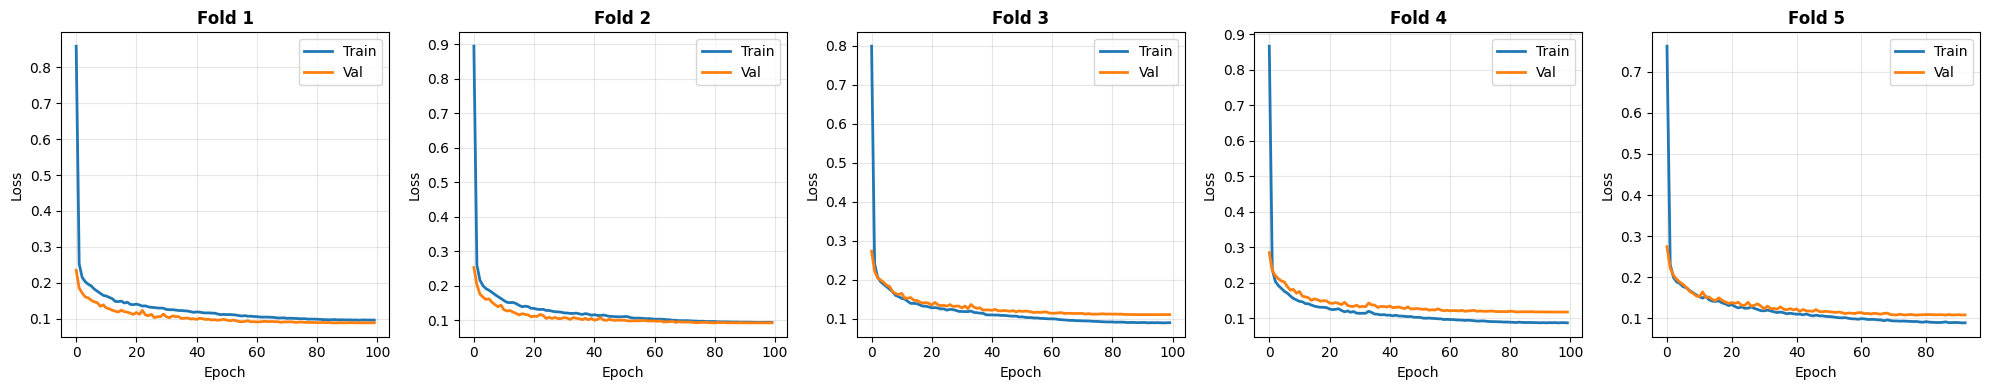

✓ Training curves saved to ../models/st_transformer_demo/training_curves.png


In [14]:
# Plot training curves
fig, axes = plt.subplots(1, cfg.N_FOLDS, figsize=(cfg.N_FOLDS * 4, 4))
if cfg.N_FOLDS == 1:
    axes = [axes]

for fold, (history, ax) in enumerate(zip(histories, axes)):
    ax.plot(history['train_loss'], label='Train', linewidth=2)
    ax.plot(history['val_loss'], label='Val', linewidth=2)
    ax.set_title(f'Fold {fold+1}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(cfg.OUTPUT_DIR / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved to {cfg.OUTPUT_DIR / 'training_curves.png'}")

## Summary

In this notebook, we:

1. ✅ Loaded and preprocessed NFL tracking data
2. ✅ Applied horizontal flip augmentation (2x data)
3. ✅ Engineered features and prepared sequences
4. ✅ Defined the 6-Layer ST Transformer model
5. ✅ Trained with 5-fold cross-validation
6. ✅ Saved trained models and scalers
7. ✅ Visualized training curves

**Trained Models**:
- Saved in: `../models/st_transformer_demo/`
- Files: `model_fold1.pt`, `scaler_fold1.pkl`, etc.
- Results: `cv_results.json`

**Next Steps:**
- For production: Train with 20-fold CV on all weeks
- See `03_inference_ensemble.ipynb` to use these models for predictions
- Try different augmentations (speed perturbation, time warp)
- Experiment with hyperparameters (hidden_dim, n_layers, etc.)